# Library Imports

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats
import itertools

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_squared_error

import datetime
import os
import math
import gc

# Data Extraction Method

In [109]:
def data_extraction(path):
    
    dataframe = pd.DataFrame()
    
    for i in os.listdir(path):
        
            df_temp = pd.read_csv(str(path) + "\\" + str(i)) # c:\\Users\\Shiva\\Documents\\TTU Mods\\PythonJ_ML_ProjectEnergyConsumptionForecast/acorn_details.csv
            df_temp = df_temp[["LCLid","day","energy_sum"]] # 
            df_temp.reset_index()
            dataframe = dataframe.append(df_temp)
    
    return dataframe

__Data Extraction__

In [110]:
myCwd = os.getcwd()
print(myCwd)
myPath = os.path.join(myCwd, "daily_dataset")
myPath = os.path.join(myPath,"daily_dataset")

print(myPath)

df = data_extraction(myPath)

c:\Users\Shiva\Documents\TTU Mods\PythonJ_ML_ProjectEnergyConsumptionForecast
c:\Users\Shiva\Documents\TTU Mods\PythonJ_ML_ProjectEnergyConsumptionForecast\daily_dataset\daily_dataset


In [111]:
df.shape

(3510433, 3)

In [112]:
df.head()

,LCLid,day,energy_sum
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [113]:
df.shape[0]

3510433

In [114]:
len(df.day.unique())

829

__Energy per household per day__

In [115]:
energy = df.groupby("day")[["energy_sum"]].sum()
# print(energy)
count_of_house = df.groupby("day")[["LCLid"]].nunique()
# print(count_of_house)
# print(len(count_of_house))

df_energy = energy.merge(count_of_house, on="day").reset_index()

df_energy["energy_per_household"] = df_energy["energy_sum"] / df_energy["LCLid"]
df_energy["day"] = pd.to_datetime(df_energy["day"])
print(df_energy)

           day    energy_sum  LCLid  energy_per_household
0   2011-11-23     90.385000     13              6.952692
1   2011-11-24    213.412000     25              8.536480
2   2011-11-25    303.993000     32              9.499781
3   2011-11-26    420.976000     41             10.267707
4   2011-11-27    444.883001     41             10.850805
..         ...           ...    ...                   ...
824 2014-02-24  51994.547004   4994             10.411403
825 2014-02-25  51423.508001   4995             10.294997
826 2014-02-26  50943.305995   4993             10.202945
827 2014-02-27  51678.185998   4990             10.356350
828 2014-02-28   1042.266000   4987              0.208997

[829 rows x 4 columns]


In [116]:
gc.collect()

80

Data Extraction for possible contributing factors to energy consumption

In [117]:
weather_df = pd.read_csv("weather_daily_darksky.csv")
holiday_df = pd.read_csv("uk_bank_holidays.csv")

Data Selection

In [118]:
weather_df = weather_df[["temperatureMax",
                         "windBearing",
                         "dewPoint",
                         "cloudCover",
                         "windSpeed",
                         "pressure",
                         "time",
                         "humidity"]]
weather_df["time"] = pd.to_datetime(weather_df["time"])

Data Cleanup

In [119]:
weather_df.isna().sum()

temperatureMax    0
windBearing       0
dewPoint          0
cloudCover        1
windSpeed         0
pressure          0
time              0
humidity          0
dtype: int64

In [120]:
row_with_NaN = weather_df.isna().any(axis = 1)
row_with_NaN
col_with_NaN = weather_df.isna().any(axis = 0)
col_with_NaN

checkRow = weather_df[row_with_NaN]
checkRow

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,time,humidity
846,11.34,187,6.78,NaN,7.2,993.32,2014-01-01,0.86


In [121]:
weather_df.dropna(inplace=True)
weather_df.isna().sum()

temperatureMax    0
windBearing       0
dewPoint          0
cloudCover        0
windSpeed         0
pressure          0
time              0
humidity          0
dtype: int64

In [122]:
weather_df

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,time,humidity
0,11.96,123,9.40,0.79,3.88,1016.08,2011-11-11,0.95
1,8.59,198,4.49,0.56,3.94,1007.71,2011-12-11,0.88
2,10.33,225,5.47,0.85,3.54,1032.76,2011-12-27,0.74
3,8.07,232,3.69,0.32,3.00,1012.12,2011-12-02,0.87
4,8.22,252,2.79,0.37,4.46,1028.17,2011-12-24,0.80
...,...,...,...,...,...,...,...,...
877,9.03,233,2.39,0.40,4.55,1002.10,2014-01-26,0.79
878,10.31,224,3.08,0.32,4.14,1007.02,2014-02-27,0.74
879,18.97,172,4.30,0.04,2.78,1022.44,2014-03-09,0.58
880,8.83,210,1.94,0.59,7.24,994.27,2014-02-12,0.75


In [123]:
weather_df.corr() # Treat correlation as gradient
# Just choose 3 most correlated factors and get a relationship from it using K-means

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,humidity
temperatureMax,1.000000,0.066226,0.854893,-0.332584,-0.147009,0.122966,-0.399969
windBearing,0.066226,1.000000,0.087704,-0.083740,0.078558,-0.030625,0.001558
dewPoint,0.854893,0.087704,1.000000,-0.003382,-0.090370,-0.026797,0.079938
cloudCover,-0.332584,-0.083740,-0.003382,1.000000,0.165238,-0.101524,0.492810
windSpeed,-0.147009,0.078558,-0.090370,0.165238,1.000000,-0.333642,-0.056839
pressure,0.122966,-0.030625,-0.026797,-0.101524,-0.333642,1.000000,-0.240828
humidity,-0.399969,0.001558,0.079938,0.492810,-0.056839,-0.240828,1.000000


In [124]:
weather_df[["cloudCover","humidity","pressure"]]

,cloudCover,humidity,pressure
0,0.79,0.95,1016.08
1,0.56,0.88,1007.71
2,0.85,0.74,1032.76
3,0.32,0.87,1012.12
4,0.37,0.80,1028.17
...,...,...,...
877,0.40,0.79,1002.10
878,0.32,0.74,1007.02
879,0.04,0.58,1022.44
880,0.59,0.75,994.27


### Scale all data from 0 to 1 so when clustering data, the centroids and data are normalized

In [125]:
scaler = MinMaxScaler(feature_range= (0,1), )
weather_scaled = scaler.fit_transform(weather_df[["cloudCover","humidity","pressure"]]).astype("float64")
print(type(weather_scaled))
pd.DataFrame(weather_scaled, columns= ["cloudCover","humidity","pressure"])


<class 'numpy.ndarray'>


,cloudCover,humidity,pressure
0,0.79,0.945455,0.597211
1,0.56,0.818182,0.461489
2,0.85,0.563636,0.867683
3,0.32,0.800000,0.532998
4,0.37,0.672727,0.793254
...,...,...,...
876,0.40,0.654545,0.370521
877,0.32,0.563636,0.450300
878,0.04,0.272727,0.700341
879,0.59,0.581818,0.243554


### Testing for best number of clusters from 2 to 14, using silhouette score and elbow method

In [126]:
def clustering_silhouette (df):
    """
    Tests posible k_mean cluster instances and scores them based on the silhouette score
    """
    silscore = []
    
    for k in range(2,15):
        
        kmeans = KMeans(n_clusters=k, random_state=42, max_iter=450)
        kmeans.fit_transform(df)
        labels = kmeans.labels_
        score = silhouette_score(df,labels, metric='euclidean')
        silscore.append(score)
        
    return silscore

In [127]:
def clustering_elbow (df):
    """
    Tests posible k_mean cluster instances and scores them based on the silhouette score
    """
    elbscore = []
    
    for k in range(2,15):
        
        kmeans = KMeans(n_clusters=k, random_state=42, max_iter=450)
        kmeans.fit_transform(df)
        within_cluster_sum_square = kmeans.inertia_
        elbscore.append(within_cluster_sum_square)
        
    return elbscore

In [128]:
silsc = clustering_silhouette(weather_scaled)
silsc

[0.3056219255554937,
 0.29307358812207773,
 0.2554918930720349,
 0.25781031531279025,
 0.2522712181551312,
 0.24628730723333409,
 0.25146980416388887,
 0.25594693718711736,
 0.2555880196218884,
 0.24526491253250907,
 0.2468858669372881,
 0.24224597119398295,
 0.24166296234709497]

In [129]:
elbsc = clustering_elbow(weather_scaled)
elbsc

[56.99556164813429,
 43.519896827698545,
 37.08154901327748,
 32.30514437752927,
 28.373467504786724,
 25.96470843547014,
 23.550042333793783,
 21.76385067159211,
 20.11503111073901,
 19.046255824427142,
 18.08095153968393,
 17.1747043371201,
 16.36353511671185]

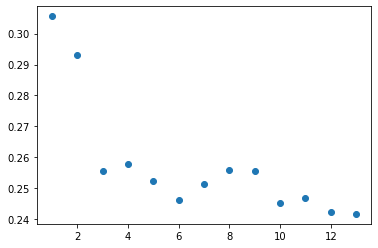

In [159]:
plt.scatter(range(1, 14),silsc)

### Use k=5 clusters as elbow is around k=5

In [131]:
kmeans = KMeans(n_clusters=5, max_iter=1000, random_state=42)
kmeans.fit_transform(weather_scaled) # gives coordinates of each point in the feature space

array([[0.18805022, 0.73017784, 0.41150915, 0.57817277, 0.34859511],
       [0.30337768, 0.53038185, 0.25498936, 0.29333757, 0.12116133],
       [0.29716066, 0.60133289, 0.4374496 , 0.68201775, 0.60501884],
       ...,
       [0.88994228, 0.29489028, 0.60237752, 0.54319367, 0.8292137 ],
       [0.5027069 , 0.55074483, 0.44212482, 0.31059679, 0.22435056],
       [0.73438053, 0.53313257, 0.5651405 , 0.31100545, 0.44452513]])

In [132]:
weather_df["Clusters"] = kmeans.fit(weather_scaled).labels_

In [133]:
kmeans.predict(weather_scaled)

array([0, 4, 0, 3, 2, 3, 2, 0, 3, 2, 0, 3, 4, 3, 0, 2, 3, 3, 2, 2, 3, 2,
       3, 3, 0, 2, 0, 2, 4, 0, 2, 4, 2, 2, 4, 0, 2, 2, 0, 2, 2, 0, 3, 0,
       0, 2, 4, 0, 3, 4, 2, 0, 3, 4, 3, 2, 2, 2, 0, 2, 3, 4, 4, 4, 4, 1,
       2, 0, 0, 4, 2, 3, 4, 1, 0, 4, 3, 2, 1, 2, 2, 0, 3, 2, 3, 1, 2, 2,
       1, 3, 3, 0, 1, 1, 2, 4, 4, 1, 1, 2, 2, 1, 3, 2, 2, 4, 1, 3, 0, 2,
       1, 1, 0, 0, 0, 1, 2, 1, 1, 4, 3, 2, 1, 3, 3, 4, 4, 3, 2, 4, 1, 2,
       2, 2, 1, 0, 3, 4, 1, 4, 2, 2, 3, 2, 3, 0, 1, 1, 4, 1, 2, 2, 2, 3,
       2, 2, 3, 1, 4, 3, 4, 3, 1, 0, 2, 4, 4, 1, 1, 3, 3, 1, 2, 2, 2, 2,
       0, 2, 3, 2, 2, 1, 0, 2, 1, 4, 3, 0, 4, 0, 2, 3, 1, 2, 3, 1, 4, 1,
       1, 0, 2, 1, 2, 3, 3, 2, 2, 0, 0, 3, 4, 4, 4, 2, 1, 3, 4, 4, 2, 3,
       1, 3, 2, 1, 3, 2, 1, 2, 2, 3, 2, 0, 0, 1, 4, 1, 2, 1, 1, 4, 0, 2,
       2, 4, 3, 3, 4, 1, 2, 0, 3, 3, 4, 2, 0, 2, 1, 0, 1, 1, 2, 0, 2, 1,
       1, 0, 1, 2, 4, 1, 3, 2, 2, 3, 4, 2, 2, 2, 4, 2, 2, 4, 1, 2, 1, 0,
       2, 4, 3, 0, 0, 1, 1, 4, 4, 1, 0, 3, 3, 2, 2,

In [134]:
centroids = kmeans.cluster_centers_

### Prep for SARIMAX

In [135]:
p = d = q = range(0,2)
type(q)

range

In [136]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [137]:
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [138]:
holiday_df["Bank holidays"]

0     2012-12-26
1     2012-12-25
2     2012-08-27
3     2012-05-06
4     2012-04-06
5     2012-07-05
6     2012-09-04
7     2012-06-04
8     2012-02-01
9     2013-12-26
10    2013-12-25
11    2013-08-26
12    2013-05-27
13    2013-06-05
14    2013-01-04
15    2013-03-29
16    2013-01-01
17    2014-12-26
18    2014-12-25
19    2014-08-25
20    2014-05-26
21    2014-05-05
22    2014-04-21
23    2014-04-18
24    2014-01-01
Name: Bank holidays, dtype: object

In [139]:
holiday_df["Bank holidays"] = pd.to_datetime(holiday_df["Bank holidays"])

In [140]:
holiday_df["Bank holidays"]

0    2012-12-26
1    2012-12-25
2    2012-08-27
3    2012-05-06
4    2012-04-06
5    2012-07-05
6    2012-09-04
7    2012-06-04
8    2012-02-01
9    2013-12-26
10   2013-12-25
11   2013-08-26
12   2013-05-27
13   2013-06-05
14   2013-01-04
15   2013-03-29
16   2013-01-01
17   2014-12-26
18   2014-12-25
19   2014-08-25
20   2014-05-26
21   2014-05-05
22   2014-04-21
23   2014-04-18
24   2014-01-01
Name: Bank holidays, dtype: datetime64[ns]

In [141]:
df_energy = df_energy.merge(weather_df, left_on="day",right_on="time")
final_df = df_energy.merge(holiday_df, left_on = "day",right_on = "Bank holidays",how = 'left')
final_df["holiday_id"] = np.where(final_df['Bank holidays'].isna(),0,1)

In [142]:
final_df.head()

,day,energy_sum,LCLid,energy_per_household,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,time,humidity,Clusters,Bank holidays,Type,holiday_id
0,2011-11-23,90.385000,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,2011-11-23,0.93,2,NaT,NaN,0
1,2011-11-24,213.412000,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,2011-11-24,0.89,2,NaT,NaN,0
2,2011-11-25,303.993000,32,9.499781,13.03,243,7.24,0.48,5.02,1024.47,2011-11-25,0.79,2,NaT,NaN,0
3,2011-11-26,420.976000,41,10.267707,12.96,237,6.96,0.44,5.75,1025.80,2011-11-26,0.81,2,NaT,NaN,0
4,2011-11-27,444.883001,41,10.850805,13.54,256,5.76,0.42,5.48,1021.11,2011-11-27,0.72,2,NaT,NaN,0


In [143]:
to_drop = ["energy_sum","LCLid","time","Bank holidays","Type", "windBearing", "dewPoint", "cloudCover", "windSpeed", "pressure", "humidity"]

final_df.drop(to_drop, axis=1, inplace=True)

In [144]:
final_df.head()

,day,energy_per_household,temperatureMax,Clusters,holiday_id
0,2011-11-23,6.952692,10.36,2,0
1,2011-11-24,8.536480,12.93,2,0
2,2011-11-25,9.499781,13.03,2,0
3,2011-11-26,10.267707,12.96,2,0
4,2011-11-27,10.850805,13.54,2,0


In [145]:
def sarimax_function(endog,exog,pdq,s_pdq):

    """
    The function uses a brute force approach to apply all possible pdq combinations and evaluate the model
    """

    result_list = []
    for param in pdq:
        for s_param in s_pdq:

            model = sm.tsa.statespace.SARIMAX(endog=endog,exog=exog, order=param, seasonal_order=s_param,
            enforce_invertibility=False,enforce_stationarity=True)

            results = model.fit()
            result_list.append([param,s_param,results.aic])
            #print("ARIMA Parameters: {} x: {}. AIC: {}".format(param,s_param,results.aic))

    return result_list,results

### Train with 70% data and test with 30% data

In [146]:
final_df.index = pd.DatetimeIndex(final_df["day"]).to_period("D")

model_data = final_df[["energy_per_household","temperatureMax","Clusters","holiday_id"]]


train = model_data.iloc[0:len(model_data)-30] 
test = model_data.iloc[len(train):len(model_data)]

del model_data

In [147]:
endog = train["energy_per_household"]
exog = train[["Clusters","holiday_id","temperatureMax"]]

In [148]:
result_list,results = sarimax_function(endog,exog,pdq,seasonal_pdq)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [149]:
results_dataframe = pd.DataFrame(result_list, columns=["dpq","s_dpq","aic"]).sort_values(by="aic")
results_dataframe.head()

,dpq,s_dpq,aic
61,"(1, 1, 1)","(1, 0, 1, 12)",609.594141
56,"(1, 1, 1)","(0, 0, 0, 12)",614.260657
57,"(1, 1, 1)","(0, 0, 1, 12)",614.472388
60,"(1, 1, 1)","(1, 0, 0, 12)",614.822305
29,"(0, 1, 1)","(1, 0, 1, 12)",635.058930


### Choose lowest AIC for better model

In [150]:
model = sm.tsa.statespace.SARIMAX(endog=endog,exog=exog, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), enforce_invertibility=False,enforce_stationarity=True).fit()

print(model.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Clusters          -0.0120      0.026     -0.463      0.643      -0.063       0.039
holiday_id        -0.0688      0.278     -0.248      0.804      -0.613       0.476
temperatureMax    -0.1151      0.013     -9.104      0.000      -0.140      -0.090
ar.L1              0.4516      0.079      5.745      0.000       0.298       0.606
ma.L1             -1.2474      0.084    -14.789      0.000      -1.413      -1.082
ar.S.L12           0.7598      0.127      5.990      0.000       0.511       1.008
ma.S.L12          -0.8792      0.102     -8.584      0.000      -1.080      -0.678
sigma2             0.1863      0.029      6.390      0.000       0.129       0.243


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test with test data

In [151]:
exog = test[["Clusters","holiday_id","temperatureMax"]]

In [152]:
predict = model.predict(start = len(train),end = len(train)+len(test)-1,
                            exog = test[["Clusters","holiday_id","temperatureMax"]])

test["prediction"] = predict.values

In [153]:
test["diff"] = test["energy_per_household"] - test["prediction"]
results = mean_squared_error(test["energy_per_household"],test["prediction"])
print(results)

4.8049544996156435


In [154]:
MAE = test['diff'].sum()/len(test)
print(MAE)

-0.6638694224798002


In [155]:
copy_test = test.copy()

### Obvious anomalous result in first row

In [156]:
copy_test.sort_values(by=["diff"])

,energy_per_household,temperatureMax,Clusters,holiday_id,prediction,diff
day,,,,,,
2014-02-28,0.208997,7.35,4,0,11.826172,-11.617175
2014-02-27,10.356350,10.31,3,0,11.561372,-1.205022
2014-02-26,10.202945,11.29,3,0,11.341837,-1.138892
2014-02-25,10.294997,11.43,4,0,11.359858,-1.064861
2014-02-21,10.518126,10.15,3,0,11.509123,-0.990997
2014-02-19,10.674624,10.13,4,0,11.398236,-0.723612
2014-02-18,10.781898,10.13,4,0,11.405452,-0.623554
2014-02-24,10.411403,14.23,3,0,11.030791,-0.619388
2014-02-03,11.280011,7.99,3,0,11.884158,-0.604147


In [157]:
### Results without the outlier ###

results = mean_squared_error(copy_test.iloc[:-1,:]["energy_per_household"],copy_test.iloc[:-1,:]["prediction"])
print(results)

0.3168923941688926


In [158]:
MAE =copy_test.iloc[:-1,:]["diff"].sum()/len(test)
print(MAE)

-0.2766302549854131


## Decent model to predict energy consumption give 1) max Temp, 2) Holiday, 3) cloudcover + humidity + pressure